# Predictive analyse of donations
In this project I explore dataset with numerous variables of potential donors and predict the possibilities of next donation. 


In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

#Loading a data
basetable=pd.read_csv('datasets/basetable_ex2_4.csv')
basetable.head()

,target,gender_F,income_high,income_low,country_USA,country_India,country_UK,age,time_since_last_gift,time_since_first_gift,max_gift,min_gift,mean_gift,number_gift
0,0,1,0,1,0,1,0,65,530,2265,166.0,87.0,116.00,7
1,0,1,0,0,0,1,0,71,715,715,90.0,90.0,90.00,1
2,0,1,0,0,0,1,0,28,150,1806,125.0,74.0,96.00,9
3,0,1,0,1,1,0,0,52,725,2274,117.0,97.0,104.25,4
4,0,1,1,0,1,0,0,82,805,805,80.0,80.0,80.00,1


## Logistic regression coefficients

In [2]:
#Creating logistic regression model
logreg = linear_model.LogisticRegression()

#Fitting model with data
variables=list(basetable.columns)
variables.remove('target')
X=basetable[variables]
y=basetable[['target']]
logreg.fit(X,y)

#Calculating coeffitiens for different variables independently
coefs=[]
for v in variables:
    xv=basetable[[v]]
    yv=basetable[['target']]
    logreg.fit(xv,yv)
    coef=list(logreg.coef_[0])
    coefs=coefs+coef

coefficients=pd.DataFrame(data={'variable':variables, 'coefficient':coefs})
coefficients_sorted=coefficients.sort_values('coefficient', ascending=False)
coefficients_sorted






,variable,coefficient
1,income_high,0.304273
12,number_gift,0.225730
0,gender_F,0.112067
4,country_India,0.085493
11,mean_gift,0.039534
9,max_gift,0.038972
10,min_gift,0.010592
5,country_UK,0.009742
6,age,0.007841
8,time_since_first_gift,0.000575


In the table above, we see that the strongest positive coefficient has variable "income_high" and strongest negative coefficient has variable "income_low". In the next step I will look for a best prediction model. 

## Building prediction model

### Model with one variable

In [3]:
#Defining a function to calculate auc score for given variable and target
def auc(variables, target, basetable):
    x=basetable[variables]
    y=basetable[target]
    logreg=linear_model.LogisticRegression()
    logreg.fit(x,y)
    predictions=logreg.predict_proba(x)[:,1]
    auc=roc_auc_score(y,predictions)
    return(auc)

#Calculating auc score for prediction models with single variable
auc_scores=[]
for v in variables:
    auc_score=auc([v], ['target'], basetable)
    auc_scores.append(str(auc_score))
auc_scores_df=pd.DataFrame(data={'variable':variables, 'auc_score':auc_scores})
auc_scores_df_sorted=auc_scores_df.sort_values('auc_score', ascending=False)
auc_scores_df_sorted


,variable,auc_score
9,max_gift,0.7065594034054515
11,mean_gift,0.6811556953291391
12,number_gift,0.6793745821618888
7,time_since_last_gift,0.6202500273207795
8,time_since_first_gift,0.5877682296463907
10,min_gift,0.5716921487845251
6,age,0.5407546606030397
1,income_high,0.5229746440170535
2,income_low,0.5159791624087584
0,gender_F,0.5140402980524574


Variable "max_gift" has a best auc score equal 0.707, which is quite good. In the next step I will build multivariable model.

### Model with multiple variables

In [4]:
#Defining function calculating next best variable for a model according to the forward stepwise procedure
def next_best(current_variables, candidate_variables, target, basetable):
    best_auc=-1
    best_variable=None
    for v in candidate_variables:
        auc_v=auc(current_variables+[v], target, basetable)
        if auc_v>=best_auc:
            best_auc=auc_v
            best_variable=v
    return best_variable
#Finding 10 variables ordered according to the forward stepwise procedure
current_variables=[]
candidate_variables=variables.copy()
target=['target']
max_number_variables=10
number_iterations=min(max_number_variables, len(candidate_variables))

for i in range(0,number_iterations):
    next_var=next_best(current_variables, candidate_variables, target, basetable)
    current_variables=current_variables+[next_var]
    candidate_variables.remove(next_var)
current_variables


['max_gift',
 'number_gift',
 'time_since_last_gift',
 'mean_gift',
 'age',
 'income_low',
 'country_UK',
 'income_high',
 'gender_F',
 'country_USA']

### Finding optimal number of variables for model
The variables ordered according to the forward stepwise procedure are given in the list "current_variables".
Adding additional variable to the model may not necessarly increase auc score. To find optimal number of variables I will partition data for to sets: train set to build model and test set to evaluate it.

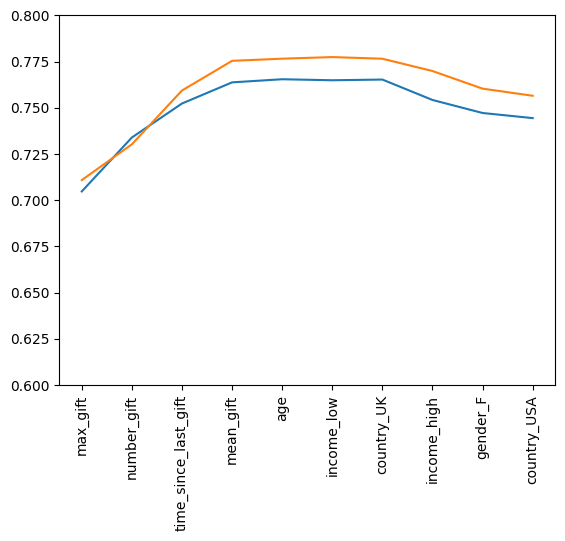

In [5]:
# Partitioning data
x=basetable[current_variables]
y=basetable[['target']]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, stratify=y)
train=pd.concat([x_train, y_train], axis=1)
test=pd.concat([x_test, y_test], axis=1)

# Defining function to calculate auc score for train set and test set
def auc_train_test(variables, target, train, test):
    X_train = train[variables]
    X_test = test[variables]
    Y_train = train[target]
    Y_test = test[target]
    logreg = linear_model.LogisticRegression()
    
    # Fit the model on train data
    logreg.fit(X_train, Y_train)
    
    # Calculate the predictions both on train and test data
    predictions_train = logreg.predict_proba(X_train)[:,1]
    predictions_test = logreg.predict_proba(X_test)[:,1]
    
    # Calculate the AUC both on train and test data
    auc_train = roc_auc_score(Y_train, predictions_train)
    auc_test = roc_auc_score(Y_test,predictions_test)
    return(auc_train, auc_test)

# Keep track of train and test AUC values
auc_values_train = []
auc_values_test = []
variables_evaluate = []

# Iterate over the variables in variables
for v in current_variables:
  
    # Add the variable
    variables_evaluate.append(v)
    
    # Calculate the train and test AUC of this set of variables
    auc_train, auc_test = auc_train_test(variables_evaluate, ["target"], train, test)
    
    # Append the values to the lists
    auc_values_train.append(auc_train)
    auc_values_test.append(auc_test)
    
# Make plot of the AUC values
import matplotlib.pyplot as plt
import numpy as np

x = np.array(range(0,len(auc_values_train)))
y_train = np.array(auc_values_train)
y_test = np.array(auc_values_test)
plt.xticks(x, current_variables, rotation = 90)
plt.plot(x,y_train)
plt.plot(x,y_test)
plt.ylim((0.6, 0.8))
plt.show()


In [6]:
final_variables=current_variables[0:4]
auc(final_variables, target, basetable)

0.7674307015371207

After adding fourth variable auc score does not increase. Therefore it is better to simplify the model and include only four variables. Auc score of this model is 0.767.

In [7]:
#Calculating probabilities of a donation using model made in a previous step
x=basetable[final_variables]
y=basetable[target]
logreg.fit(x,y)
predictions=logreg.predict_proba(basetable[final_variables])

basetable2=basetable.copy()
basetable2['predict_proba']=predictions[:,1]
basetable2_sorted=basetable2.sort_values('predict_proba', ascending=False)


## Cumulative gains curve

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

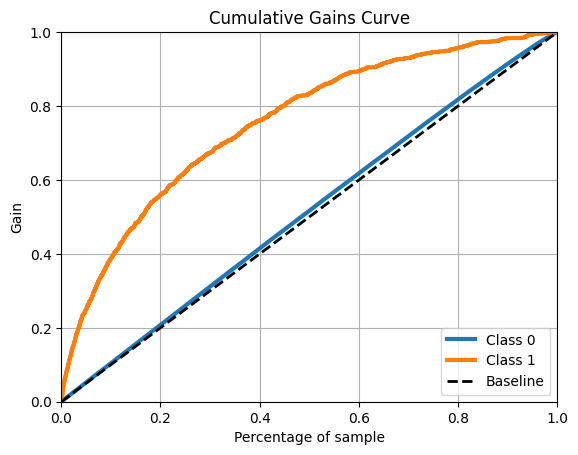

In [8]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(basetable[target], predictions)

This cumulative gains curve of our model tells us that if we address 50% of donors with highest probability of donation, we can reach over 80% of possible donations

## Lift curve of a model

<AxesSubplot: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

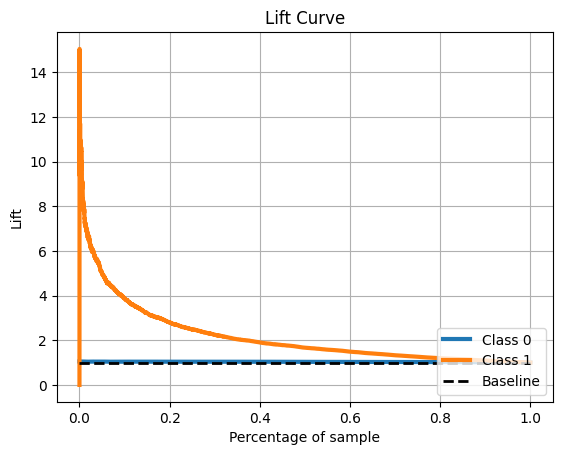

In [9]:
skplt.metrics.plot_lift_curve(basetable[target], predictions)

## Predictor insight graphs

### Calculating predictor insight graph table

In [27]:
# Which values need to be discretized
def check_discretize(basetable, variable, threshold):
    return(len(basetable.groupby(variable))>threshold)
# Discretization
threshold=5
number_of_bins=5
for variable in variables:
    if check_discretize(basetable, variable, threshold):
        new_variable="disc"+variable
        basetable[new_variable]=pd.qcut(basetable[variable], number_of_bins)
        
# Creating predictor insight graph table
def create_pig_table(df, target, variable):
    groups=df[[target, variable]].groupby(variable)
    pig_table=groups[target].agg(Incidence='mean', Size='size').reset_index()
    return pig_table

all_variables=list(basetable.columns)
all_variables.remove('target')

pig_variables=[]
for variable in all_variables:
    if not check_discretize(basetable, variable, 5):
        pig_variables.append(variable)

pig_tables={}

for variable in pig_variables:
    pig_table=create_pig_table(basetable, 'target', variable)
    pig_tables[variable]=pig_table

pig_tables['discage']
    

,discage,Incidence,Size
0,"(18.999, 38.0]",0.039638,5298
1,"(38.0, 49.0]",0.044227,5110
2,"(49.0, 59.0]",0.048106,4885
3,"(59.0, 68.0]",0.047279,4907
4,"(68.0, 109.0]",0.059167,4800


### Plotting predictor insight graph

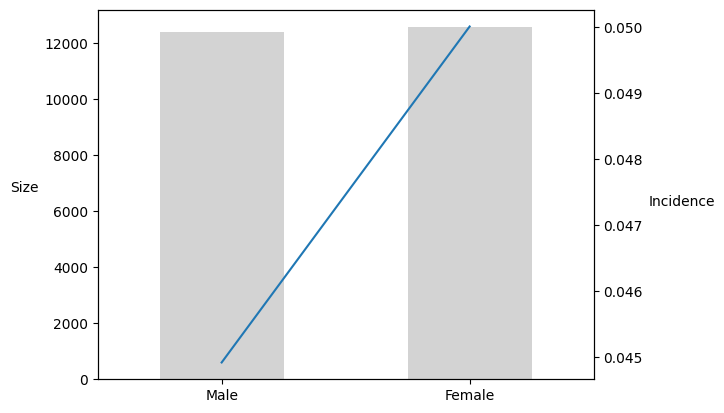

In [38]:
# Plotting predictor insight graph for gender
pig_gender=pig_tables['gender_F']
pig_gender.loc[0, 'gender_F']='Male'
pig_gender.loc[1, 'gender_F']='Female'

pig_gender['Size'].plot(kind='bar', width=0.5, color='lightgray', edgecolor='none')
plt.ylabel('Size', rotation=0, rotation_mode='anchor', ha='right')
pig_gender['Incidence'].plot(secondary_y=True)

plt.xticks(np.arange(len(pig_gender)), pig_gender['gender_F'])
width=0.5
plt.xlim([-width, len(pig_gender)-width])
plt.ylabel('Incidence', rotation=0, rotation_mode='anchor', ha='left')
plt.xlabel('Gender')
plt.show()

Predictor insight graph above shows that both groups have simillar sizes but women are more likely to donate.

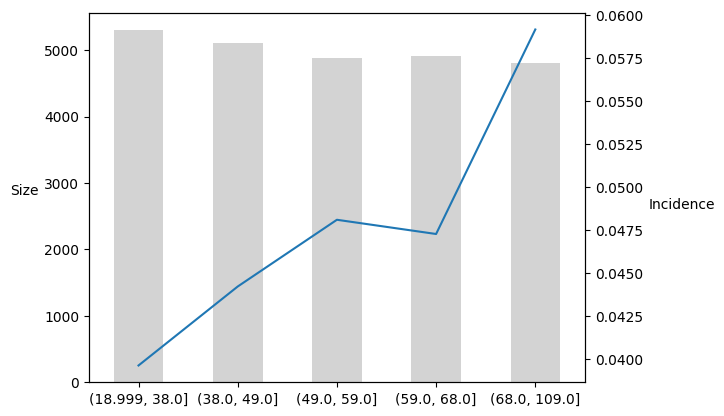

In [40]:
# Plotting predictor insight graph for age
pig_age=pig_tables['discage']

pig_age['Size'].plot(kind='bar', width=0.5, color='lightgray', edgecolor='none')
plt.ylabel('Size', rotation=0, rotation_mode='anchor', ha='right')
pig_age['Incidence'].plot(secondary_y=True)

plt.xticks(np.arange(len(pig_age)), pig_age['discage'])
width=0.5
plt.xlim([-width, len(pig_age)-width])
plt.ylabel('Incidence', rotation=0, rotation_mode='anchor', ha='left')
plt.xlabel('Age')
plt.show()

Predictor insight graph above shows that older people are most likely to donate.